# Formulary status

The formulary status of a drug on an insurance plan can be reflected by its rejection rate and associated copayment. Generally, if a drug is covered by the insurance plan, the copayment is lower after the deductible is meet. The prefered drug on the formulary usually has a low price estimated by the copayment before the deductible is meet and a low, if not zero, rejection rate.

## 1. Rejection rates

The rejection rate of a drug on an insurance plan can be estimated from the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
%matplotlib inline

In [2]:
#import data
df_original = pd.read_csv('pharmacy_tx.csv')
df = df_original.copy()

In [3]:
# the insurance plan is uniquely determined by bin, pcn and group
# missing data in pcn and group are treated as not required and form a class within the category
df['bin'] = df['bin'].astype(str)
df['pcn'] = df['pcn'].astype(str).str.upper()
df['group'] = df['group'].astype(str).str.upper()
df['rejected'][df['rejected'] == False] = 0
df['rejected'][df['rejected'] == True] = 1

<ipython-input-3-3af655975e22>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rejected'][df['rejected'] == False] = 0


In [4]:
# get rejection rates
formula = df.groupby(['bin', 'pcn', 'group', 'drug']).rejected.mean().to_frame()
formula.columns = ['rejection_rate']
formula

rejection_rate
bin    pcn     group    drug                                   
160389 RB7UU   RS5RB3YA branded antimab                0.000000
                        branded bovirol                0.000000
                        branded brede                  0.208267
                        branded choxestamenium         0.322488
                        branded cibroniudosin          0.000000
...                                                         ...
96934  S76J7V6 NAN      generic tanoclolol             0.000000
                        generic thiostasteglume        0.000000
                        generic todiadianic            0.000000
                        generic tovane                 0.000000
                        generic vocopirin              0.000000

[7087 rows x 1 columns]

## 2. Copayments and formulary status

In [5]:
# copayment is 0 if the claim is rejected
print(pd.unique(df[df['rejected'] == 1]['patient_pay']))
print(pd.unique(df[df['patient_pay'] == 0]['rejected']))

[0.]
[1.]


As shown above, the copayment is always 0 if the claim is rejected, which means the patient refuses to pay anything if the claim is rejected. As a result, zero copayment should be excluded from the data for getting copayments.

In [6]:
# excluding zero copayment
# only approved claims in data present no need for 'rejected' column
df = df[df['rejected'] == 0].drop(columns = ['rejected'])

For a drug on an insurance plan in a pharmacy, there is either one copayment or two copayments.

In [7]:
# confirm only one or two copayments for a drug on an insurance plan in a pharmacy
df_pharmacy = df[['bin', 'pcn', 'group', 'drug', 'pharmacy', 'patient_pay']]
df_pharmacy_groups = df_pharmacy.groupby(['bin', 'pcn', 'group', 'drug', 'pharmacy'])
copayment_uniques = set(len(pd.unique(group['patient_pay'])) for name, group in df_pharmacy_groups)
copayment_uniques

{1, 2}

<ipython-input-8-809c3f468ad5>:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


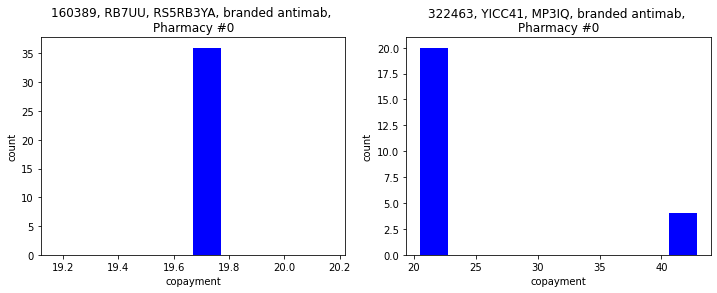

In [8]:
# plotting two typical distributions of a drug on an insurance plan in a pharmacy
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# branded antimab on the insurance ('160389', 'RB7UU', 'RS5RB3YA') in Pharmacy #0 has one copayment
axs[0].hist(df_pharmacy_groups.get_group(('160389', 'RB7UU', 'RS5RB3YA', 'branded antimab', 'Pharmacy #0'))['patient_pay'], 
            color = 'b')
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('count')
axs[0].set_title('160389, RB7UU, RS5RB3YA, branded antimab, \nPharmacy #0')

# branded antimab on the insurance ('322463', 'YICC41', 'MP3IQ') in Pharmacy #0 has two copayments
axs[1].hist(df_pharmacy_groups.get_group(('322463', 'YICC41', 'MP3IQ', 'branded antimab', 'Pharmacy #0'))['patient_pay'], 
            color = 'b')
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('count')
axs[1].set_title('322463, YICC41, MP3IQ, branded antimab, \nPharmacy #0')

fig.show()

The copayments for the drug on an insurance plan can be obtained as following. If a drug on an insurance plan has one copayment in all the pharmacies, a Gaussian mixture model with one component is fitted to extract the mean for copayment and the standard deviation for fluctuation. If a drug on an insurance plan has two copayment in any pharmacy, a Gaussian mixture model with two components is fitted to extract two means for high copayment and low copayment and two standard deviations for fluctuations around them.

In [9]:
# getting drugs having two copayments on an insurance plan
two_copayments = set(name[:4] for name, group in df_pharmacy_groups if len(pd.unique(group['patient_pay'])) == 2)

In [10]:
# getting all the drugs on all the insurance plans
df_drug = df[['bin', 'pcn', 'group', 'drug', 'patient_pay']]
df_drug_groups = df_drug.groupby(['bin', 'pcn', 'group', 'drug'])

In [11]:
# fitting Gaussian mixture model and updating formula
for name, group in df_drug_groups:
    if name in two_copayments:
        gm = GaussianMixture(n_components = 2, init_params = 'k-means++', random_state = 614)
        gm.fit(group['patient_pay'].to_numpy().reshape(-1, 1))
        means = np.round(gm.means_.ravel(), 2)
        stds = np.round(np.sqrt(gm.covariances_.ravel()), 2)
        if means[0] > means[1]:
            formula.loc[name, 'copayment_high'] = means[0]
            formula.loc[name, 'std_high'] = stds[0]
            formula.loc[name, 'copayment_low'] = means[1]
            formula.loc[name, 'std_low'] = stds[1]
        else:
            formula.loc[name, 'copayment_high'] = means[1]
            formula.loc[name, 'std_high'] = stds[1]
            formula.loc[name, 'copayment_low'] = means[0]
            formula.loc[name, 'std_low'] = stds[0]
    else:
        try:
            gm = GaussianMixture(n_components = 1, init_params = 'k-means++', random_state = 614)
            gm.fit(group['patient_pay'].to_numpy().reshape(-1, 1))
            formula.loc[name, 'copayment_high'] = np.round(gm.means_.ravel(), 2)[0]
            formula.loc[name, 'std_high'] = np.round(np.sqrt(gm.covariances_.ravel()), 2)[0]
        except:
            formula.loc[name, 'copayment_high'] = group['patient_pay'].to_numpy()[0]
            formula.loc[name, 'std_high'] = 0
        formula.loc[name, 'copayment_low'] = formula.loc[name, 'copayment_high']
        formula.loc[name, 'std_low'] = formula.loc[name, 'std_high']

The distribution of the ratio of extracted standard deviation to extracted mean is well concentrated around 0, which confirms copayments only has small fluctuations and Gaussian is a suitable model.

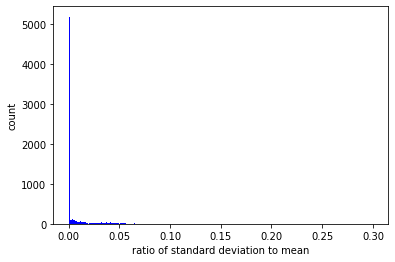

In [12]:
# confirm Gaussian mixture is a suitable model
bins = np.linspace(0, 0.3, 300)
plt.hist(formula['std_high'] / formula['copayment_high'], bins, color = 'b')
plt.xlabel('ratio of standard deviation to mean')
plt.ylabel('count')
plt.show()
plt.close()

In [13]:
formula

rejection_rate  \
bin    pcn     group    drug                                      
160389 RB7UU   RS5RB3YA branded antimab                0.000000   
                        branded bovirol                0.000000   
                        branded brede                  0.208267   
                        branded choxestamenium         0.322488   
                        branded cibroniudosin          0.000000   
...                                                         ...   
96934  S76J7V6 NAN      generic tanoclolol             0.000000   
                        generic thiostasteglume        0.000000   
                        generic todiadianic            0.000000   
                        generic tovane                 0.000000   
                        generic vocopirin              0.000000   

                                                 copayment_high  std_high  \
bin    pcn     group    drug                                                
160389 RB7UU   RS5RB3YA branded antimab                   20.63      0.73   
                        branded bovirol                   12.54      0.00   
                        branded brede                     18.71      0.73   
                        branded choxestamenium           132.07      0.72   
                        branded cibroniudosin             12.54      0.00   
...                                                         ...       ...   
96934  S76J7V6 NAN      generic tanoclolol                 6.17      0.00   
                        generic thiostasteglume           23.95      0.00   
                        generic todiadianic               63.25      0.00   
                        generic tovane                     9.38      0.00   
                        generic vocopirin                 17.35      0.00   

                                                 copayment_low  std_low  
bin    pcn     group    drug                                             
160389 RB7UU   RS5RB3YA branded antimab                  20.63     0.73  
                        branded bovirol                  12.54     0.00  
                        branded brede                    18.71     0.73  
                        branded choxestamenium          132.07     0.72  
                        branded cibroniudosin            12.54     0.00  
...                                                        ...      ...  
96934  S76J7V6 NAN      generic tanoclolol                6.17     0.00  
                        generic thiostasteglume          15.57     0.74  
                        generic todiadianic              29.09     0.69  
                        generic tovane                    9.38     0.00  
                        generic vocopirin                13.28     0.77  

[7087 rows x 5 columns]

Now that the copayment for each drug on each insurance plan has been identified, if two copayments are identified, the difference between the two copayments can be interpreted as the coverage by the insurance after the deductible is meet. The copayment differences for all the drugs on each insurance plan are plotted against the higher copayments below with color set by the rejection rate.

In [14]:
# getting copayments
copayments = formula.copy().reset_index()
copayments_groups = copayments.groupby(['bin', 'pcn', 'group'])

<ipython-input-15-7b7b667dffd1>:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


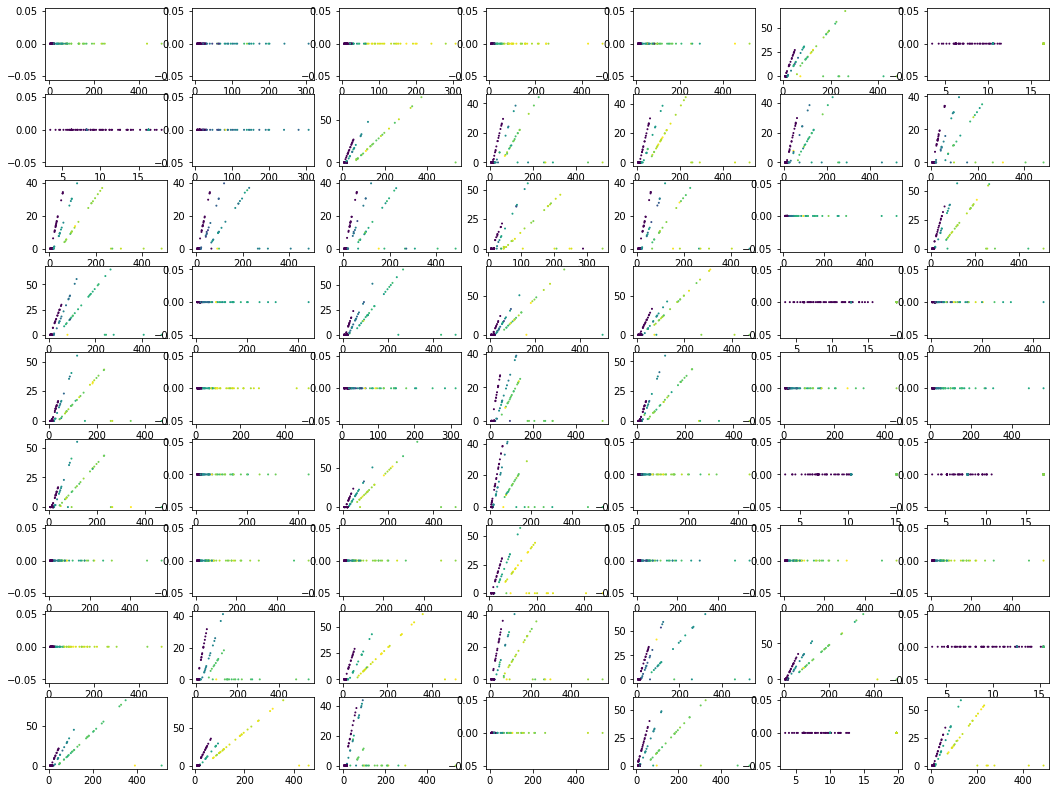

In [15]:
# plotting difference between two copayments against the higher copayment
fig, axs = plt.subplots(9, 7, figsize = (18, 14))
n = 0
for name, group in copayments_groups:
    axs[n // 7, n % 7].scatter(group['copayment_high'], group['copayment_high'] - group['copayment_low'], 
                               c = group['rejection_rate'], s = 1)
    n += 1

fig.show()

There are three categories of insurances can be identified:
* **Category 1** (23 insurances): one copayment for each drug on each plan with a large range of copayments, for example, ('322463', '9FU70', 'U19J4RVCA')
* **Category 2** (7 insurances): one copayment for each drug on each plan with a small range of copayments below 20, for example, ('322463', 'T52GV', 'EVD4X5')
* **Category 3** (33 insurances): two copayments for most of drugs with one copayment for some of the drugs, for example, ('539437', 'RAM3J', '7DUPMODV0')

<ipython-input-16-c143de07433d>:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


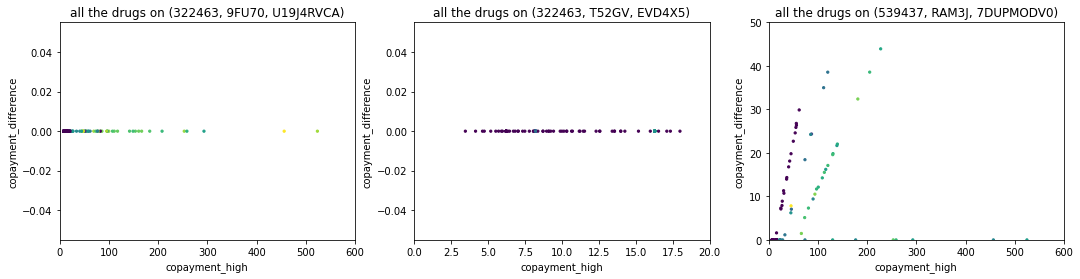

In [16]:
# plotting difference between two copayments against the higher copayment
fig, axs = plt.subplots(1, 3, figsize = (18, 4))

# insurance ('322463', '9FU70', 'U19J4RVCA')
sample = copayments_groups.get_group(('322463', '9FU70', 'U19J4RVCA'))
axs[0].scatter(sample['copayment_high'], sample['copayment_high'] - sample['copayment_low'], 
               c = sample['rejection_rate'], s = 5)
axs[0].set_xlabel('copayment_high')
axs[0].set_ylabel('copayment_difference')
axs[0].set_xlim([0, 600])
axs[0].set_title('all the drugs on (322463, 9FU70, U19J4RVCA)')

# insurance ('322463', 'T52GV', 'EVD4X5')
sample = copayments_groups.get_group(('322463', 'T52GV', 'EVD4X5'))
axs[1].scatter(sample['copayment_high'], sample['copayment_high'] - sample['copayment_low'], 
               c = sample['rejection_rate'], s = 5)
axs[1].set_xlabel('copayment_high')
axs[1].set_ylabel('copayment_difference')
axs[1].set_xlim([0, 20])
axs[1].set_title('all the drugs on (322463, T52GV, EVD4X5)')

# insurance ('539437', 'RAM3J', '7DUPMODV0')
sample = copayments_groups.get_group(('539437', 'RAM3J', '7DUPMODV0'))
axs[2].scatter(sample['copayment_high'], sample['copayment_high'] - sample['copayment_low'], 
               c = sample['rejection_rate'], s = 5)
axs[2].set_xlabel('copayment_high')
axs[2].set_ylabel('copayment_difference')
axs[2].set_xlim([0, 600])
axs[2].set_ylim([0, 50])
axs[2].set_title('all the drugs on (539437, RAM3J, 7DUPMODV0)')

fig.show()

In [17]:
# getting insurances for three categories
insurance1, insurance2, insurance3 = [], [], []
n = 0
for name, group in copayments_groups:
    if n in [0, 1, 2, 3, 4, 8, 19, 22, 27, 29, 30, 33, 34, 36, 39, 42, 43, 44, 46, 47, 48, 49, 59]:
        insurance1.append(name)
    elif n in [6, 7, 26, 40, 41, 55, 61]:
        insurance2.append(name)
    else:
        insurance3.append(name)
    n += 1

### 2.1. Formulary status for drugs on insurances in category 1

For the insurances in the category 1, rejection rate and copayment are used to cluster the drugs.

In [18]:
# getting insurances in category 1
copayment1 = pd.concat([copayments_groups.get_group(insurance) for insurance in insurance1])
copayment1_groups = copayment1.groupby(['bin', 'pcn', 'group'])

<ipython-input-19-2f14a6127615>:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


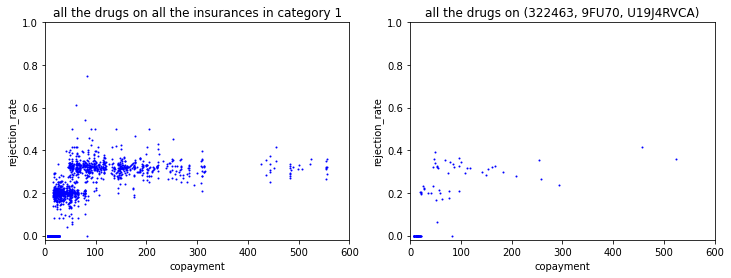

In [19]:
# plotting drugs on insurances in category 1 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 1
axs[0].scatter(copayment1['copayment_high'], copayment1['rejection_rate'], c = 'b', s = 1)
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('rejection_rate')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([-0.02, 1])
axs[0].set_title('all the drugs on all the insurances in category 1')

# all the drugs on insurance ('322463', '9FU70', 'U19J4RVCA')
sample = copayment1_groups.get_group(('322463', '9FU70', 'U19J4RVCA'))
axs[1].scatter(sample['copayment_high'], sample['rejection_rate'], c = 'b', s = 1)
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('rejection_rate')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([-0.02, 1])
axs[1].set_title('all the drugs on (322463, 9FU70, U19J4RVCA)')

fig.show()

Tier 1 is assigned to drugs with zero rejection rate.

<ipython-input-20-3036e8061cba>:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


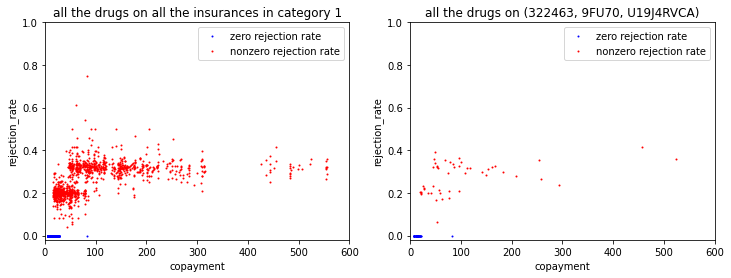

In [20]:
# plotting drugs on insurances in category 1 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 1
tier1 = copayment1[copayment1['rejection_rate'] == 0]
left = copayment1[copayment1['rejection_rate'] != 0]
plot1,  = axs[0].plot(tier1['copayment_high'], tier1['rejection_rate'], 'bo', ms = 1, label = 'zero rejection rate')
plot2,  = axs[0].plot(left['copayment_high'], left['rejection_rate'], 'ro', ms = 1, label = 'nonzero rejection rate')
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('rejection_rate')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([-0.02, 1])
axs[0].legend(handles = [plot1, plot2])
axs[0].set_title('all the drugs on all the insurances in category 1')

# all the drugs on insurance ('322463', '9FU70', 'U19J4RVCA')
sample = copayment1_groups.get_group(('322463', '9FU70', 'U19J4RVCA'))
sample_tier1 = sample[sample['rejection_rate'] == 0]
sample_left = sample[sample['rejection_rate'] != 0]
plot1,  = axs[1].plot(sample_tier1['copayment_high'], sample_tier1['rejection_rate'], 'bo', ms = 1, 
                      label = 'zero rejection rate')
plot2,  = axs[1].plot(sample_left['copayment_high'], sample_left['rejection_rate'], 'ro', ms = 1, 
                      label = 'nonzero rejection rate')
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('rejection_rate')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([-0.02, 1])
axs[1].legend(handles = [plot1, plot2])
axs[1].set_title('all the drugs on (322463, 9FU70, U19J4RVCA)')

fig.show()

Labels for three tiers of drugs with nonzero rejection rate are obtained from clustering with kmeans.

<ipython-input-21-530e10ca574c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left['class'] = pipe.fit_predict(left[['copayment_high', 'rejection_rate']])
<ipython-input-21-530e10ca574c>:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


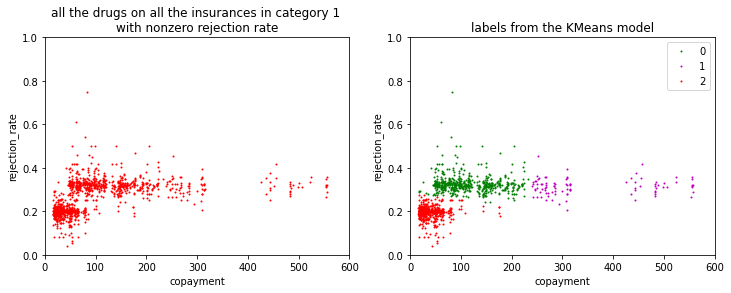

In [21]:
# plotting drugs with nonzero rejection rate on insurances in category 1 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 1
axs[0].plot(left['copayment_high'], left['rejection_rate'], 'ro', ms = 1)
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('rejection_rate')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([0, 1])
axs[0].set_title('all the drugs on all the insurances in category 1 \nwith nonzero rejection rate')

# labels obtained from kmeans
pipe = Pipeline([('scaler', StandardScaler()), ('km', KMeans(n_clusters = 3, random_state = 614))])
left['class'] = pipe.fit_predict(left[['copayment_high', 'rejection_rate']])
class1 = left[left['class'] == 0]
class2 = left[left['class'] == 1]
class3 = left[left['class'] == 2]
plot1,  = axs[1].plot(class1['copayment_high'], class1['rejection_rate'], 'go', ms = 1, label = 0)
plot2,  = axs[1].plot(class2['copayment_high'], class2['rejection_rate'], 'mo', ms = 1, label = 1)
plot3,  = axs[1].plot(class3['copayment_high'], class3['rejection_rate'], 'ro', ms = 1, label = 2)
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('rejection_rate')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([0, 1])
axs[1].legend(handles = [plot1, plot2, plot3])
axs[1].set_title('labels from the KMeans model')

fig.show()

There are four tiers for drugs on insurances in category 1

<ipython-input-22-e7644f1f145e>:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


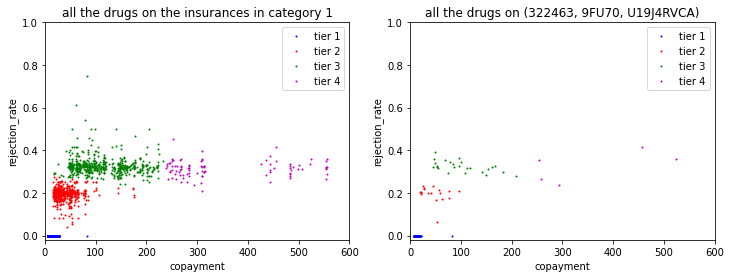

In [22]:
# plotting drugs on insurances in category 1 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 1
tier2 = left[left['class'] == 2]
tier3 = left[left['class'] == 0]
tier4 = left[left['class'] == 1]
plot1,  = axs[0].plot(tier1['copayment_high'], tier1['rejection_rate'], 'bo', ms = 1, label = 'tier 1')
plot2,  = axs[0].plot(tier2['copayment_high'], tier2['rejection_rate'], 'ro', ms = 1, label = 'tier 2')
plot3,  = axs[0].plot(tier3['copayment_high'], tier3['rejection_rate'], 'go', ms = 1, label = 'tier 3')
plot4,  = axs[0].plot(tier4['copayment_high'], tier4['rejection_rate'], 'mo', ms = 1, label = 'tier 4')
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('rejection_rate')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([-0.02, 1])
axs[0].legend(handles = [plot1, plot2, plot3, plot4])
axs[0].set_title('all the drugs on the insurances in category 1')

# all the drugs on insurance ('322463', '9FU70', 'U19J4RVCA')
left_groups = left.groupby(['bin', 'pcn', 'group'])
sample = left_groups.get_group(('322463', '9FU70', 'U19J4RVCA'))
sample_tier2 = sample[sample['class'] == 2]
sample_tier3 = sample[sample['class'] == 0]
sample_tier4 = sample[sample['class'] == 1]
plot1,  = axs[1].plot(sample_tier1['copayment_high'], sample_tier1['rejection_rate'], 'bo', ms = 1, label = 'tier 1')
plot2,  = axs[1].plot(sample_tier2['copayment_high'], sample_tier2['rejection_rate'], 'ro', ms = 1, label = 'tier 2')
plot3,  = axs[1].plot(sample_tier3['copayment_high'], sample_tier3['rejection_rate'], 'go', ms = 1, label = 'tier 3')
plot4,  = axs[1].plot(sample_tier4['copayment_high'], sample_tier4['rejection_rate'], 'mo', ms = 1, label = 'tier 4')
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('rejection_rate')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([-0.02, 1])
axs[1].legend(handles = [plot1, plot2, plot3, plot4])
axs[1].set_title('all the drugs on (322463, 9FU70, U19J4RVCA)')

fig.show()

<ipython-input-23-fc6d3a0f9ee3>:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


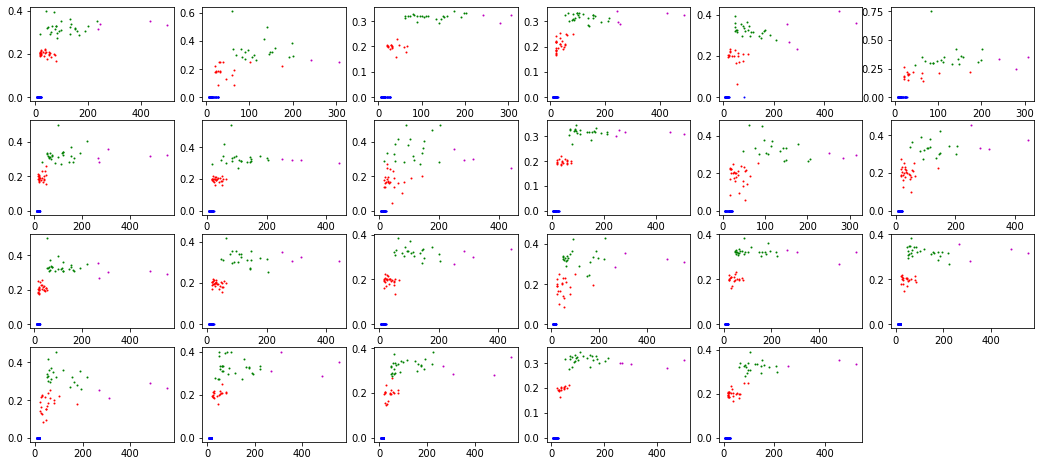

In [23]:
# clusters for all the drugs on each insurance in category 1
tier1_groups = tier1.groupby(['bin', 'pcn', 'group'])

fig, axs = plt.subplots(4, 6, figsize = (18, 8))
n = 0
for name, group in copayment1_groups:
    sample_tier1 = tier1_groups.get_group(name)
    sample_left = left_groups.get_group(name)
    sample_tier2 = sample_left[sample_left['class'] == 2]
    sample_tier3 = sample_left[sample_left['class'] == 0]
    sample_tier4 = sample_left[sample_left['class'] == 1]
    axs[n // 6, n % 6].plot(sample_tier1['copayment_high'], sample_tier1['rejection_rate'], 'bo', ms = 1)
    axs[n // 6, n % 6].plot(sample_tier2['copayment_high'], sample_tier2['rejection_rate'], 'ro', ms = 1)
    axs[n // 6, n % 6].plot(sample_tier3['copayment_high'], sample_tier3['rejection_rate'], 'go', ms = 1)
    axs[n // 6, n % 6].plot(sample_tier4['copayment_high'], sample_tier4['rejection_rate'], 'mo', ms = 1)
    n += 1

axs[3, 5].set_axis_off()

fig.show()

### 2.2. Formulary status for drugs on insurances in category 2

For the insurances in the category 2, rejection rate and copayment are used to cluster the drugs.

In [24]:
# getting insurances in category 2
copayment2 = pd.concat([copayments_groups.get_group(insurance) for insurance in insurance2])
copayment2_groups = copayment2.groupby(['bin', 'pcn', 'group'])

<ipython-input-25-beeff520bf78>:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


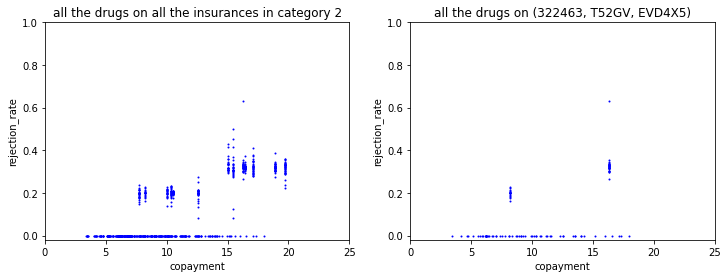

In [25]:
# plotting drugs on insurances in category 2 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 2
axs[0].scatter(copayment2['copayment_high'], copayment2['rejection_rate'], c = 'b', s = 1)
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('rejection_rate')
axs[0].set_xlim([0, 25])
axs[0].set_ylim([-0.02, 1])
axs[0].set_title('all the drugs on all the insurances in category 2')

# all the drugs on insurance ('322463', 'T52GV', 'EVD4X5')
sample = copayment2_groups.get_group(('322463', 'T52GV', 'EVD4X5'))
axs[1].scatter(sample['copayment_high'], sample['rejection_rate'], c = 'b', s = 1)
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('rejection_rate')
axs[1].set_xlim([0, 25])
axs[1].set_ylim([-0.02, 1])
axs[1].set_title('all the drugs on (322463, T52GV, EVD4X5)')

fig.show()

Tier 1 is assigned to drugs with zero rejection rate.

<ipython-input-26-a9aba60387e7>:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


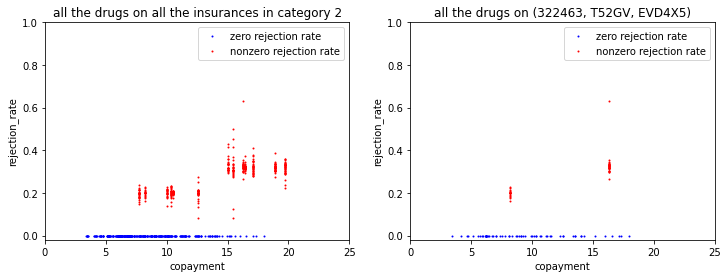

In [26]:
# plotting drugs on insurances in category 2 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 2
tier1 = copayment2[copayment2['rejection_rate'] == 0]
left = copayment2[copayment2['rejection_rate'] != 0]
plot1,  = axs[0].plot(tier1['copayment_high'], tier1['rejection_rate'], 'bo', ms = 1, label = 'zero rejection rate')
plot2,  = axs[0].plot(left['copayment_high'], left['rejection_rate'], 'ro', ms = 1, label = 'nonzero rejection rate')
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('rejection_rate')
axs[0].set_xlim([0, 25])
axs[0].set_ylim([-0.02, 1])
axs[0].legend(handles = [plot1, plot2])
axs[0].set_title('all the drugs on all the insurances in category 2')

# all the drugs on insurance ('322463', 'T52GV', 'EVD4X5')
sample = copayment2_groups.get_group(('322463', 'T52GV', 'EVD4X5'))
sample_tier1 = sample[sample['rejection_rate'] == 0]
sample_left = sample[sample['rejection_rate'] != 0]
plot1,  = axs[1].plot(sample_tier1['copayment_high'], sample_tier1['rejection_rate'], 'bo', ms = 1, 
                      label = 'zero rejection rate')
plot2,  = axs[1].plot(sample_left['copayment_high'], sample_left['rejection_rate'], 'ro', ms = 1, 
                      label = 'nonzero rejection rate')
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('rejection_rate')
axs[1].set_xlim([0, 25])
axs[1].set_ylim([-0.02, 1])
axs[1].legend(handles = [plot1, plot2])
axs[1].set_title('all the drugs on (322463, T52GV, EVD4X5)')

fig.show()

Labels for three tiers of drugs with nonzero rejection rate are obtained from clustering with kmeans.

<ipython-input-27-a77419fce4c3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left['class'] = pipe.fit_predict(left[['copayment_high', 'rejection_rate']])
<ipython-input-27-a77419fce4c3>:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


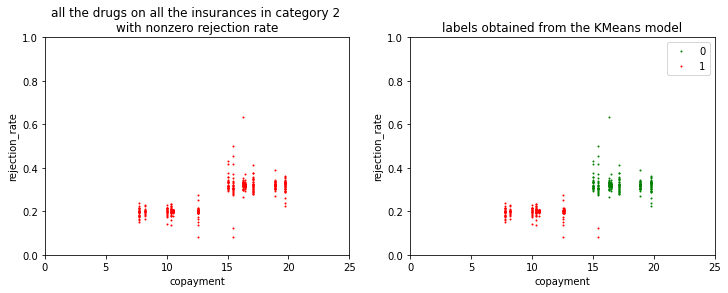

In [27]:
# plotting drugs with nonzero rejection rate on insurances in category 2 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 2
axs[0].plot(left['copayment_high'], left['rejection_rate'], 'ro', ms = 1)
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('rejection_rate')
axs[0].set_xlim([0, 25])
axs[0].set_ylim([0, 1])
axs[0].set_title('all the drugs on all the insurances in category 2 \nwith nonzero rejection rate')

# labels obtained from kmeans
pipe = Pipeline([('scaler', StandardScaler()), ('km', KMeans(n_clusters = 2, random_state = 614))])
left['class'] = pipe.fit_predict(left[['copayment_high', 'rejection_rate']])
class1 = left[left['class'] == 0]
class2 = left[left['class'] == 1]
plot1,  = axs[1].plot(class1['copayment_high'], class1['rejection_rate'], 'go', ms = 1, label = 0)
plot2,  = axs[1].plot(class2['copayment_high'], class2['rejection_rate'], 'ro', ms = 1, label = 1)
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('rejection_rate')
axs[1].set_xlim([0, 25])
axs[1].set_ylim([0, 1])
axs[1].legend(handles = [plot1, plot2])
axs[1].set_title('labels obtained from the KMeans model')

fig.show()

There are three tiers for drugs on insurances in category 2

<ipython-input-28-da249d5bb59c>:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


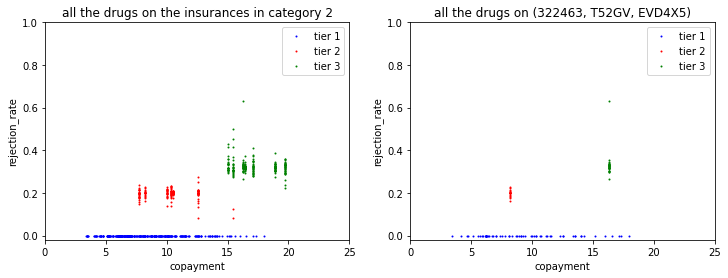

In [28]:
# plotting drugs on insurances in category 2 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 1
tier2 = left[left['class'] == 1]
tier3 = left[left['class'] == 0]
plot1,  = axs[0].plot(tier1['copayment_high'], tier1['rejection_rate'], 'bo', ms = 1, label = 'tier 1')
plot2,  = axs[0].plot(tier2['copayment_high'], tier2['rejection_rate'], 'ro', ms = 1, label = 'tier 2')
plot3,  = axs[0].plot(tier3['copayment_high'], tier3['rejection_rate'], 'go', ms = 1, label = 'tier 3')
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('rejection_rate')
axs[0].set_xlim([0, 25])
axs[0].set_ylim([-0.02, 1])
axs[0].legend(handles = [plot1, plot2, plot3])
axs[0].set_title('all the drugs on the insurances in category 2')

# all the drugs on insurance ('322463', 'T52GV', 'EVD4X5')
left_groups = left.groupby(['bin', 'pcn', 'group'])
sample = left_groups.get_group(('322463', 'T52GV', 'EVD4X5'))
sample_tier2 = sample[sample['class'] == 1]
sample_tier3 = sample[sample['class'] == 0]
plot1,  = axs[1].plot(sample_tier1['copayment_high'], sample_tier1['rejection_rate'], 'bo', ms = 1, label = 'tier 1')
plot2,  = axs[1].plot(sample_tier2['copayment_high'], sample_tier2['rejection_rate'], 'ro', ms = 1, label = 'tier 2')
plot3,  = axs[1].plot(sample_tier3['copayment_high'], sample_tier3['rejection_rate'], 'go', ms = 1, label = 'tier 3')
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('rejection_rate')
axs[1].set_xlim([0, 25])
axs[1].set_ylim([-0.02, 1])
axs[1].legend(handles = [plot1, plot2, plot3])
axs[1].set_title('all the drugs on (322463, T52GV, EVD4X5)')

fig.show()

<ipython-input-29-0f6bf0106946>:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


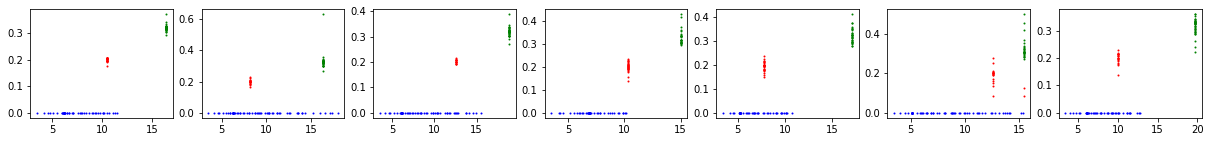

In [29]:
# clusters for all the drugs on each insurance in category 2
tier1_groups = tier1.groupby(['bin', 'pcn', 'group'])

fig, axs = plt.subplots(1, 7, figsize = (21, 2))
n = 0
for name, group in copayment2_groups:
    sample_tier1 = tier1_groups.get_group(name)
    sample_left = left_groups.get_group(name)
    sample_tier2 = sample_left[sample_left['class'] == 1]
    sample_tier3 = sample_left[sample_left['class'] == 0]
    axs[n % 7].plot(sample_tier1['copayment_high'], sample_tier1['rejection_rate'], 'bo', ms = 1)
    axs[n % 7].plot(sample_tier2['copayment_high'], sample_tier2['rejection_rate'], 'ro', ms = 1)
    axs[n % 7].plot(sample_tier3['copayment_high'], sample_tier3['rejection_rate'], 'go', ms = 1)
    n += 1

fig.show()

### 2.3. Formulary status for drugs on insurances in category 3

For the insurances in the category 3, difference between high and low copayment and high copayment are used to cluster the drugs, since the difference here is similar to the converage from the insurance.

In [30]:
# getting insurances in category 3
copayment3 = pd.concat([copayments_groups.get_group(insurance) for insurance in insurance3])
copayment3_groups = copayment3.groupby(['bin', 'pcn', 'group'])

<ipython-input-31-3c1a6848a457>:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


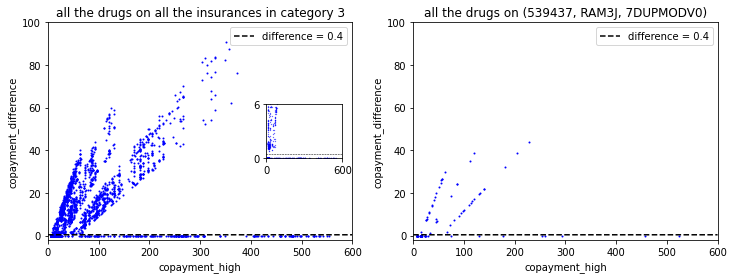

In [31]:
# plotting drugs on insurances in category 3 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 3
axs[0].scatter(copayment3['copayment_high'], copayment3['copayment_high'] - copayment3['copayment_low'], c = 'b', s = 1)
line,  = axs[0].plot(np.linspace(0, 600, 6000), np.ones(6000) * 0.4, 'k--', label = 'difference = 0.4')
axs[0].set_xlabel('copayment_high')
axs[0].set_ylabel('copayment_difference')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([-2, 100])
axs[0].legend(handles = [line])
axs[0].set_title('all the drugs on all the insurances in category 3')
axins = inset_axes(axs[0], width = '25%', height = '25%', loc = 'center right', borderpad = 1)
axins.plot(copayment3['copayment_high'], copayment3['copayment_high'] - copayment3['copayment_low'], 'bo', ms = 0.25)
axins.plot(np.linspace(0, 600, 6000), np.ones(6000) * 0.4, 'k--', linewidth = 0.5)
axins.set_xlim([0, 600])
axins.set_ylim([0, 6])
axins.set_xticks([0, 600])
axins.set_yticks([0, 6])

# all the drugs on insurance ('539437', 'RAM3J', '7DUPMODV0')
sample = copayment3_groups.get_group(('539437', 'RAM3J', '7DUPMODV0'))
axs[1].scatter(sample['copayment_high'], sample['copayment_high'] - sample['copayment_low'], c = 'b', s = 1)
line,  = axs[1].plot(np.linspace(0, 600, 6000), np.ones(6000) * 0.4, 'k--', label = 'difference = 0.4')
axs[1].set_xlabel('copayment_high')
axs[1].set_ylabel('copayment_difference')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([-2, 100])
axs[1].legend(handles = [line])
axs[1].set_title('all the drugs on (539437, RAM3J, 7DUPMODV0)')

fig.show()

Tier 1 is assigned to drugs with zero rejection rate. All the insurances in category 3 have three linear branches in addition to the data points with zero copayment difference. For the three linear branches with positive slop, the intercept with copayment_high axis can be interpreted as a minimum copayment required before the coverage takes effect and the slope can be interpreted as the percentage covered above the minimum copayment. Since the data points with zero copayment difference form a line with zero slop, they can be classified as not covered. However this becomes less unambiguous when copayment_high approaches zero especially when it falls within the range of minimum copayment for other tiers.

<ipython-input-32-f92713024c54>:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


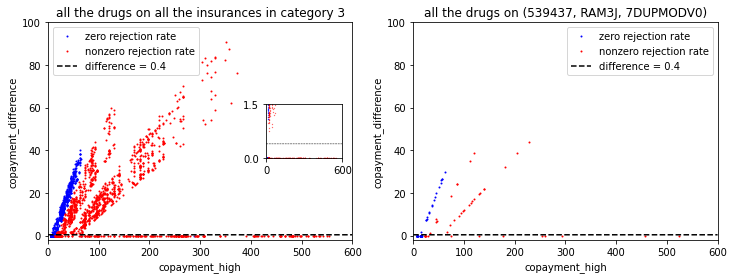

In [32]:
# plotting drugs on insurances in category 3 with respect to copayment and copayment difference
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 3
tier1 = copayment3[copayment3['rejection_rate'] == 0]
left = copayment3[copayment3['rejection_rate'] != 0]
plot1,  = axs[0].plot(tier1['copayment_high'], tier1['copayment_high'] - tier1['copayment_low'], 
                      'bo', ms = 1, label = 'zero rejection rate')
plot2,  = axs[0].plot(left['copayment_high'], left['copayment_high'] - left['copayment_low'], 
                      'ro', ms = 1, label = 'nonzero rejection rate')
line,  = axs[0].plot(np.linspace(0, 600, 6000), np.ones(6000) * 0.4, 'k--', label = 'difference = 0.4')
axs[0].set_xlabel('copayment_high')
axs[0].set_ylabel('copayment_difference')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([-2, 100])
axs[0].legend(handles = [plot1, plot2, line])
axs[0].set_title('all the drugs on all the insurances in category 3')
axins = inset_axes(axs[0], width = '25%', height = '25%', loc = 'center right', borderpad = 1)
axins.plot(tier1['copayment_high'], tier1['copayment_high'] - tier1['copayment_low'], 'bo', ms = 0.25)
axins.plot(left['copayment_high'], left['copayment_high'] - left['copayment_low'], 'ro', ms = 0.25)
axins.plot(np.linspace(0, 600, 6000), np.ones(6000) * 0.4, 'k--', linewidth = 0.5)
axins.set_xlim([0, 600])
axins.set_ylim([0, 1.5])
axins.set_xticks([0, 600])
axins.set_yticks([0, 1.5])

# all the drugs on insurance ('539437', 'RAM3J', '7DUPMODV0')
sample = copayment3_groups.get_group(('539437', 'RAM3J', '7DUPMODV0'))
sample_tier1 = sample[sample['rejection_rate'] == 0]
sample_left = sample[sample['rejection_rate'] != 0]
plot1,  = axs[1].plot(sample_tier1['copayment_high'], sample_tier1['copayment_high'] - sample_tier1['copayment_low'], 
                      'bo', ms = 1, label = 'zero rejection rate')
plot2,  = axs[1].plot(sample_left['copayment_high'], sample_left['copayment_high'] - sample_left['copayment_low'], 
                      'ro', ms = 1, label = 'nonzero rejection rate')
line,  = axs[1].plot(np.linspace(0, 600, 6000), np.ones(6000) * 0.4, 'k--', label = 'difference = 0.4')
axs[1].set_xlabel('copayment_high')
axs[1].set_ylabel('copayment_difference')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([-2, 100])
axs[1].legend(handles = [plot1, plot2, line])
axs[1].set_title('all the drugs on (539437, RAM3J, 7DUPMODV0)')

fig.show()

For now, data points with zero copayment difference are left out in order to draw a linear boundary between two remaining clusters, which can be achieved by getting labels through fitting a Gaussian mixture model with two components and then fitting a linear SVM classifier.

<ipython-input-33-bed62eba417a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['copayment_difference'] = sample['copayment_high'] - sample['copayment_low']
<ipython-input-33-bed62eba417a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['class'] = gm.fit_predict(sample[['copayment_high', 'copayment_difference']])
<ipython-input-33-bed62eba417a>:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f

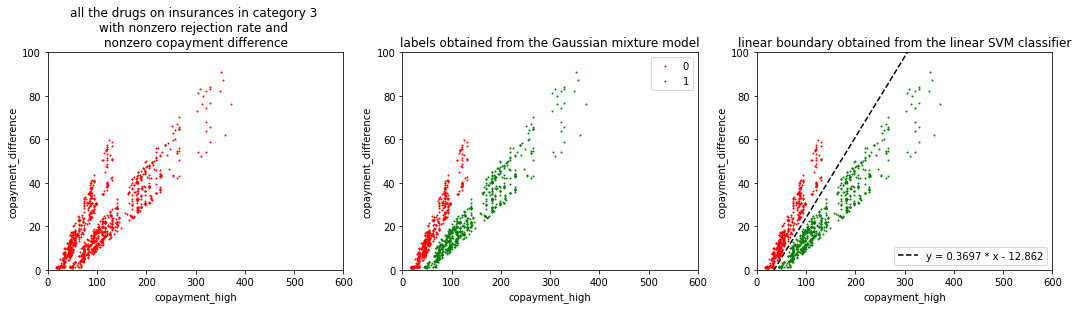

In [33]:
# all the drugs on insurances in category 3 with nonzero rejection rate and nonzero copayment difference
fig, axs = plt.subplots(1, 3, figsize = (18, 4))

# all the drugs on insurances in category 3
sample = left[left['copayment_high'] - left['copayment_low'] > 0]
sample['copayment_difference'] = sample['copayment_high'] - sample['copayment_low']
axs[0].plot(sample['copayment_high'], sample['copayment_difference'], 'ro', label = 0, ms = 1)
axs[0].set_xlabel('copayment_high')
axs[0].set_ylabel('copayment_difference')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([0, 100])
axs[0].set_title('all the drugs on insurances in category 3 \nwith nonzero rejection rate and \nnonzero copayment difference')

# getting labels from the Gaussian mixture model
gm = GaussianMixture(n_components = 2, init_params = 'k-means++', random_state = 614)
sample['class'] = gm.fit_predict(sample[['copayment_high', 'copayment_difference']])
class1 = sample[sample['class'] == 0]
class2 = sample[sample['class'] == 1]
plot1,  = axs[1].plot(class1['copayment_high'], class1['copayment_difference'], 'ro', label = 0, ms = 1)
plot2,  = axs[1].plot(class2['copayment_high'], class2['copayment_difference'], 'go', label = 1, ms = 1)
axs[1].set_xlabel('copayment_high')
axs[1].set_ylabel('copayment_difference')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([0, 100])
axs[1].legend(handles = [plot1, plot2])
axs[1].set_title('labels obtained from the Gaussian mixture model')

# getting linear boundary from the linear SVM classifier
svc = LinearSVC(max_iter = 1000000)
svc.fit(sample[['copayment_high', 'copayment_difference']], sample['class'])
slop = round(-svc.coef_[0][0] / svc.coef_[0][1], 4)
intcpt = -round(svc.intercept_[0] / svc.coef_[0][1], 4)
line,  = axs[2].plot(np.linspace(0, 400, 4000), slop * np.linspace(0, 400, 4000) + intcpt, 'k--', 
                     label = 'y = ' + str(slop) + ' * x - ' + str(abs(intcpt)))
axs[2].plot(class1['copayment_high'], class1['copayment_difference'], 'ro', ms = 1)
axs[2].plot(class2['copayment_high'], class2['copayment_difference'], 'go', ms = 1)
axs[2].set_xlabel('copayment_high')
axs[2].set_ylabel('copayment_difference')
axs[2].set_xlim([0, 600])
axs[2].set_ylim([0, 100])
axs[2].legend(handles = [line])
axs[2].set_title('linear boundary obtained from the linear SVM classifier')

fig.show()

A seperate tier is assigned to the drugs to the right of the linear boundary with zero copayment difference. There are four tiers for drugs on insurances in category 3. 

<ipython-input-34-c07cf78d352f>:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


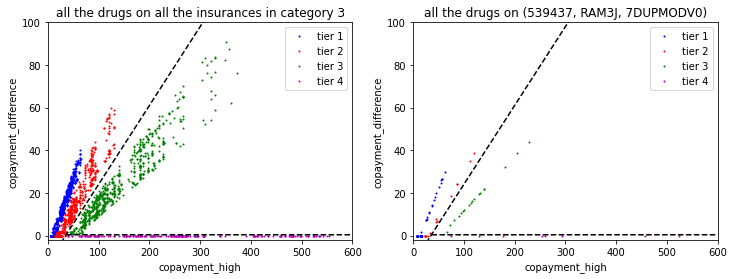

In [34]:
# plotting drugs on insurances in category 3 with respect to copayment and copayment difference
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 3
tier2 = left[0.6303 * left['copayment_high']- left['copayment_low'] + 12.862 > 0]
tier3 = left[(0.6303 * left['copayment_high'] - left['copayment_low'] + 12.862 <= 0) & 
             (left['copayment_high'] > left['copayment_low'])]
tier4  = left[(0.6303 * left['copayment_high'] - left['copayment_low'] + 12.862 <= 0) & 
             (left['copayment_high'] == left['copayment_low'])]
plot1,  = axs[0].plot(tier1['copayment_high'], tier1['copayment_high'] - tier1['copayment_low'], 'bo', ms = 1, label = 'tier 1')
plot2,  = axs[0].plot(tier2['copayment_high'], tier2['copayment_high'] - tier2['copayment_low'], 'ro', ms = 1, label = 'tier 2')
plot3,  = axs[0].plot(tier3['copayment_high'], tier3['copayment_high'] - tier3['copayment_low'], 'go', ms = 1, label = 'tier 3')
plot4,  = axs[0].plot(tier4['copayment_high'], tier4['copayment_high'] - tier4['copayment_low'], 'mo', ms = 1, label = 'tier 4')
line1,  = axs[0].plot(np.linspace(36, 600, 6000), np.ones(6000) * 0.4, 'k--')
line2,  = axs[0].plot(np.linspace(0, 400, 4000), slop * np.linspace(0, 400, 4000) + intcpt, 'k--')
axs[0].set_xlabel('copayment_high')
axs[0].set_ylabel('copayment_difference')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([-2, 100])
axs[0].legend(handles = [plot1, plot2, plot3, plot4])
axs[0].set_title('all the drugs on all the insurances in category 3')

# all the drugs on insurance ('539437', 'RAM3J', '7DUPMODV0')
left_groups = left.groupby(['bin', 'pcn', 'group'])
sample = copayment3_groups.get_group(('539437', 'RAM3J', '7DUPMODV0'))
sample_tier1 = sample[sample['rejection_rate'] == 0]
sample_left = sample[sample['rejection_rate'] != 0]
sample_tier2 = sample_left[0.6303 * sample_left['copayment_high']- sample_left['copayment_low'] + 12.862 > 0]
sample_tier3 = sample_left[(0.6303 * sample_left['copayment_high'] - sample_left['copayment_low'] + 12.862 <= 0) & 
                           (sample_left['copayment_high'] > sample_left['copayment_low'])]
sample_tier4 = sample_left[(0.6303 * sample_left['copayment_high'] - sample_left['copayment_low'] + 12.862 <= 0) & 
                           (sample_left['copayment_high'] == sample_left['copayment_low'])]
plot1,  = axs[1].plot(sample_tier1['copayment_high'], sample_tier1['copayment_high'] - sample_tier1['copayment_low'], 
                      'bo', ms = 1, label = 'tier 1')
plot2,  = axs[1].plot(sample_tier2['copayment_high'], sample_tier2['copayment_high'] - sample_tier2['copayment_low'], 
                      'ro', ms = 1, label = 'tier 2')
plot3,  = axs[1].plot(sample_tier3['copayment_high'], sample_tier3['copayment_high'] - sample_tier3['copayment_low'], 
                      'go', ms = 1, label = 'tier 3')
plot4,  = axs[1].plot(sample_tier4['copayment_high'], sample_tier4['copayment_high'] - sample_tier4['copayment_low'], 
                      'mo', ms = 1, label = 'tier 4')
line1,  = axs[1].plot(np.linspace(36, 600, 6000), np.ones(6000) * 0.4, 'k--')
line2,  = axs[1].plot(np.linspace(0, 400, 4000), slop * np.linspace(0, 400, 4000) + intcpt, 'k--')
axs[1].set_xlabel('copayment_high')
axs[1].set_ylabel('copayment_difference')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([-2, 100])
axs[1].legend(handles = [plot1, plot2, plot3, plot4])
axs[1].set_title('all the drugs on (539437, RAM3J, 7DUPMODV0)')

fig.show()

<ipython-input-35-572d25136e17>:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


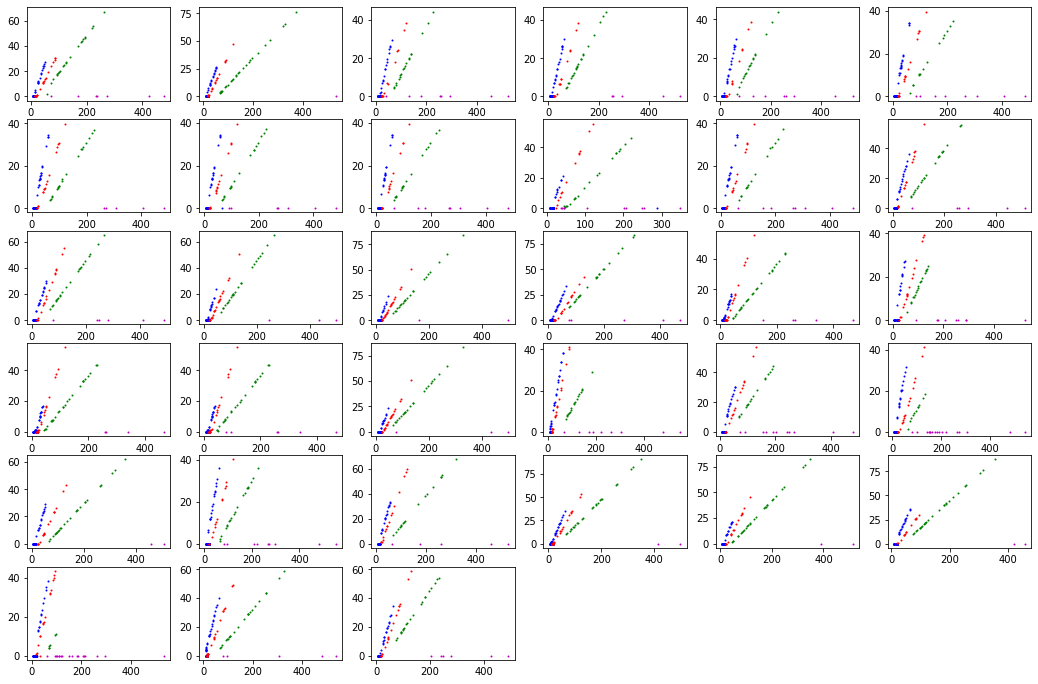

In [35]:
# clusters for all the drugs on each insurance in category 3
tier1_groups = tier1.groupby(['bin', 'pcn', 'group'])

fig, axs = plt.subplots(6, 6, figsize = (18, 12))
n = 0
for name, group in copayment3_groups:
    sample_tier1 = tier1_groups.get_group(name)
    sample_left = left_groups.get_group(name)
    sample_tier2 = sample_left[0.6303 * sample_left['copayment_high']- sample_left['copayment_low'] + 12.862 > 0]
    sample_tier3 = sample_left[(0.6303 * sample_left['copayment_high'] - sample_left['copayment_low'] + 12.862 <= 0) & 
                               (sample_left['copayment_high'] > sample_left['copayment_low'])]
    sample_tier4 = sample_left[(0.6303 * sample_left['copayment_high'] - sample_left['copayment_low'] + 12.862 <= 0) & 
                               (sample_left['copayment_high'] == sample_left['copayment_low'])]
    axs[n // 6, n % 6].plot(sample_tier1['copayment_high'], sample_tier1['copayment_high'] - sample_tier1['copayment_low'], 
                            'bo', ms = 1)
    axs[n // 6, n % 6].plot(sample_tier2['copayment_high'], sample_tier2['copayment_high'] - sample_tier2['copayment_low'], 
                            'ro', ms = 1)
    axs[n // 6, n % 6].plot(sample_tier3['copayment_high'], sample_tier3['copayment_high'] - sample_tier3['copayment_low'], 
                            'go', ms = 1)
    axs[n // 6, n % 6].plot(sample_tier4['copayment_high'], sample_tier4['copayment_high'] - sample_tier4['copayment_low'], 
                            'mo', ms = 1)
    n += 1

axs[5, 3].set_axis_off()
axs[5, 4].set_axis_off()
axs[5, 5].set_axis_off()

fig.show()